In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from analyzeradprofile import *
from fitellipse import *

In [2]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/AS209tapered.image.fits',
                          'distance':121,
                          'incl' : 34.7,
                          'PA' : 86.2,
                          'offsetx' : 0.39*.003,
                          'offsety' : -1.12*.003,
                          'size': 3.5,
                          'gamma': 0.6
                         }

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


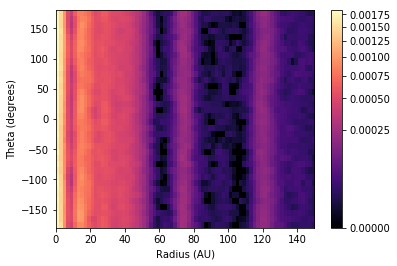

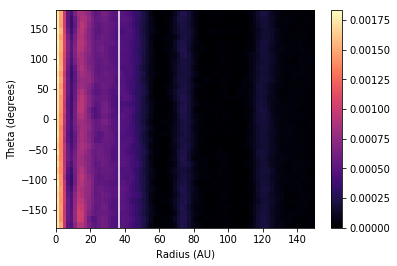

In [3]:


#make some preliminary plots
cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
    
radialbins = 1+2*np.arange(75)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0)
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.vlines(37,-180,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


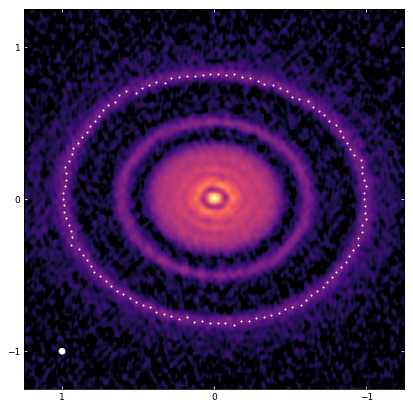

In [3]:
# Extract the ring that's at ~120 AU
xcoords1, ycoords1 = cont.extract_ring(110,130,tbins = -178.5+3*np.arange(120), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.5, 2.5)

In [4]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     1.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -1.706e-04 arcsec, delta_y = 1.751e-03 arcsec
The MLE semi-major axis is r = 0.994 arcsec
The MLE inclination is i = 34.926 degrees
The MLE position angle is PA = 85.666 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.518e+00


In [5]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    #flat priors on x0, y0, r0, logvar
    if not (-4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -15<logvar<-5):
        return -np.inf
    #gaussian prior on PA and cosi based on Fedele+ 2018
    sig_par = .0122
    sig_cosi = .008
    return -0.5*((par-1.50)/sig_par)**2-0.5*((cosi-0.816)/sig_cosi)**2

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000

In [6]:
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

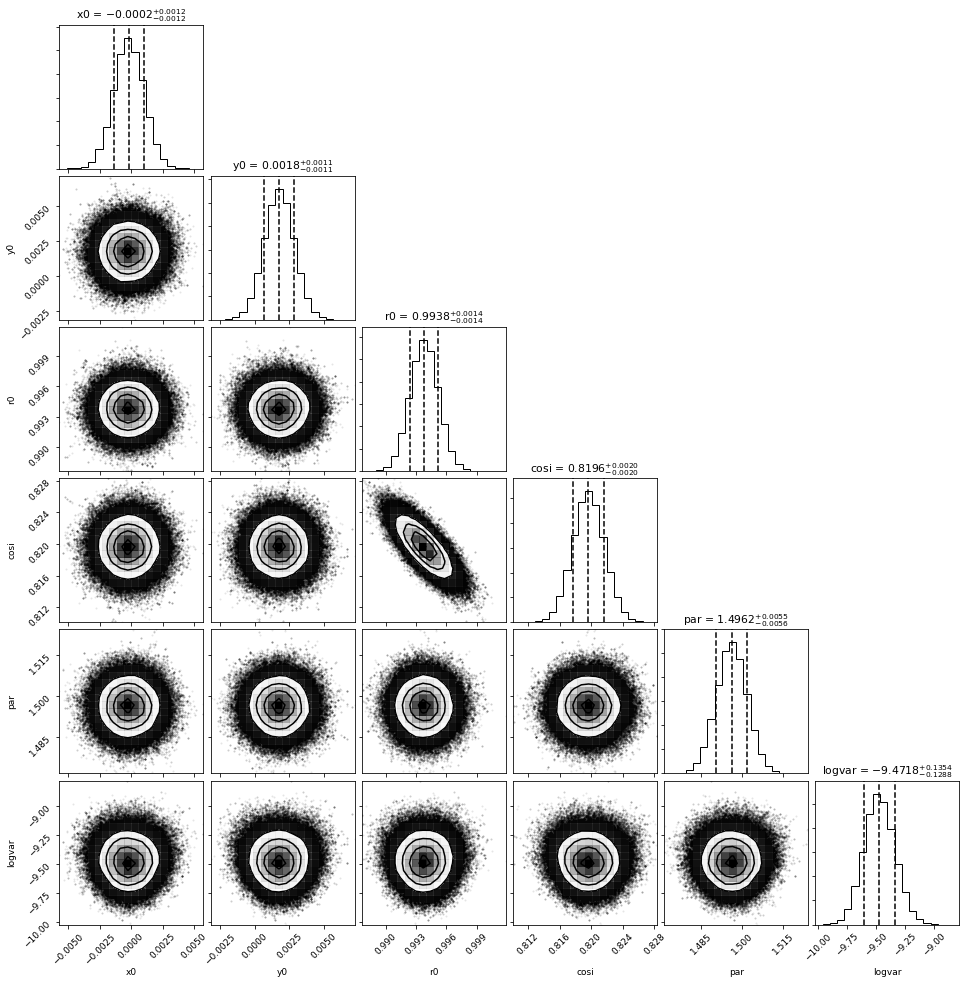

The x offset is delta_x = -1.97e-04 arcsec (+1.2e-03, -1.2e-03)
The y offset is delta_y = 1.76e-03 arcsec (+1.1e-03, -1.1e-03)
The median semi-major axis is r = 0.9938 arcsec (+0.0014, -0.0014) 
or 120.25 AU (+0.13, -0.13)
The incl is i = 34.95 deg (+0.20, -0.20)
The median position angle is PA = 85.73 deg (+0.32, -0.32)
The median log-variance in the pixel offsets from the true ellipse is -9.472e+00


In [8]:
plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


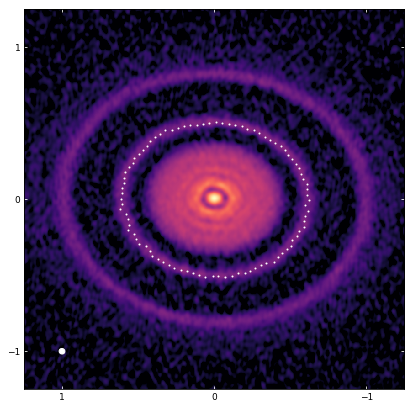

In [9]:
# Extract the ring that's at ~75 AU
xcoords2, ycoords2 = cont.extract_ring(65,85,tbins = -178+4*np.arange(90))

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.5, 2.5)

In [10]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     75/121.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -6.724e-04 arcsec, delta_y = -4.197e-03 arcsec
The MLE semi-major axis is r = 0.611 arcsec
The MLE inclination is i = 34.475 degrees
The MLE position angle is PA = 85.463 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.919e+00


In [11]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

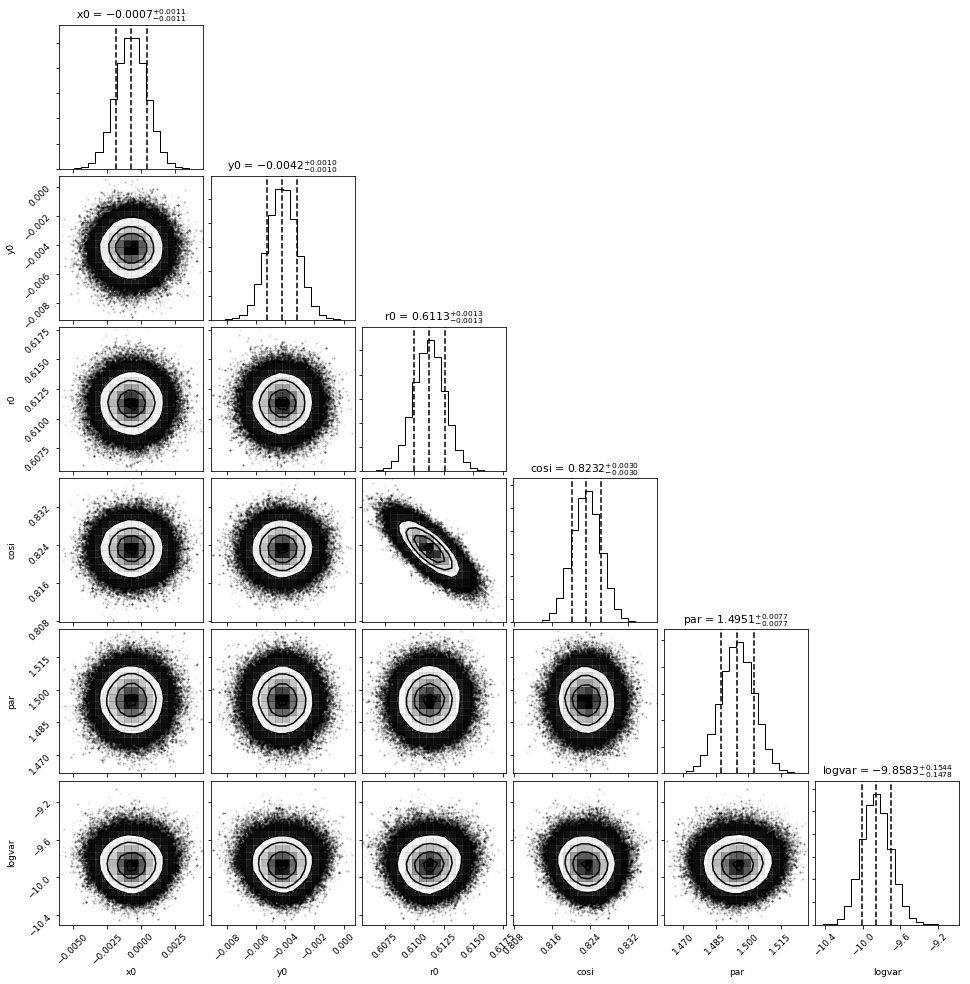

The x offset is delta_x = -6.74e-04 arcsec (+1.1e-03, -1.1e-03)
The y offset is delta_y = -4.21e-03 arcsec (+1.0e-03, -1.0e-03)
The median semi-major axis is r = 0.6113 arcsec (+0.0013, -0.0013) 
or 73.96 AU (+0.12, -0.12)
The incl is i = 34.59 deg (+0.30, -0.30)
The median position angle is PA = 85.66 deg (+0.44, -0.44)
The median log-variance in the pixel offsets from the true ellipse is -9.858e+00


In [13]:
plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


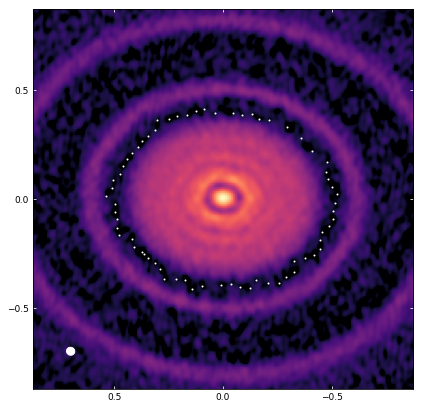

In [14]:
# Extract the gap that's at ~60 AU
xcoords3, ycoords3 = cont.extract_ring(55,65,tbins = -177.5+5*np.arange(72), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords3, ycoords3, 0.5, 1.75)

In [15]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_3 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     0.5,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords3, ycoords3)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -2.928e-03 arcsec, delta_y = -4.449e-03 arcsec
The MLE semi-major axis is r = 0.507 arcsec
The MLE inclination is i = 36.771 degrees
The MLE position angle is PA = 86.431 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.631e+00


In [16]:
sampler3 = run_mcmc(nwalkers, nthreads, nsteps, mle_3, lnprob, xcoords3, ycoords3)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

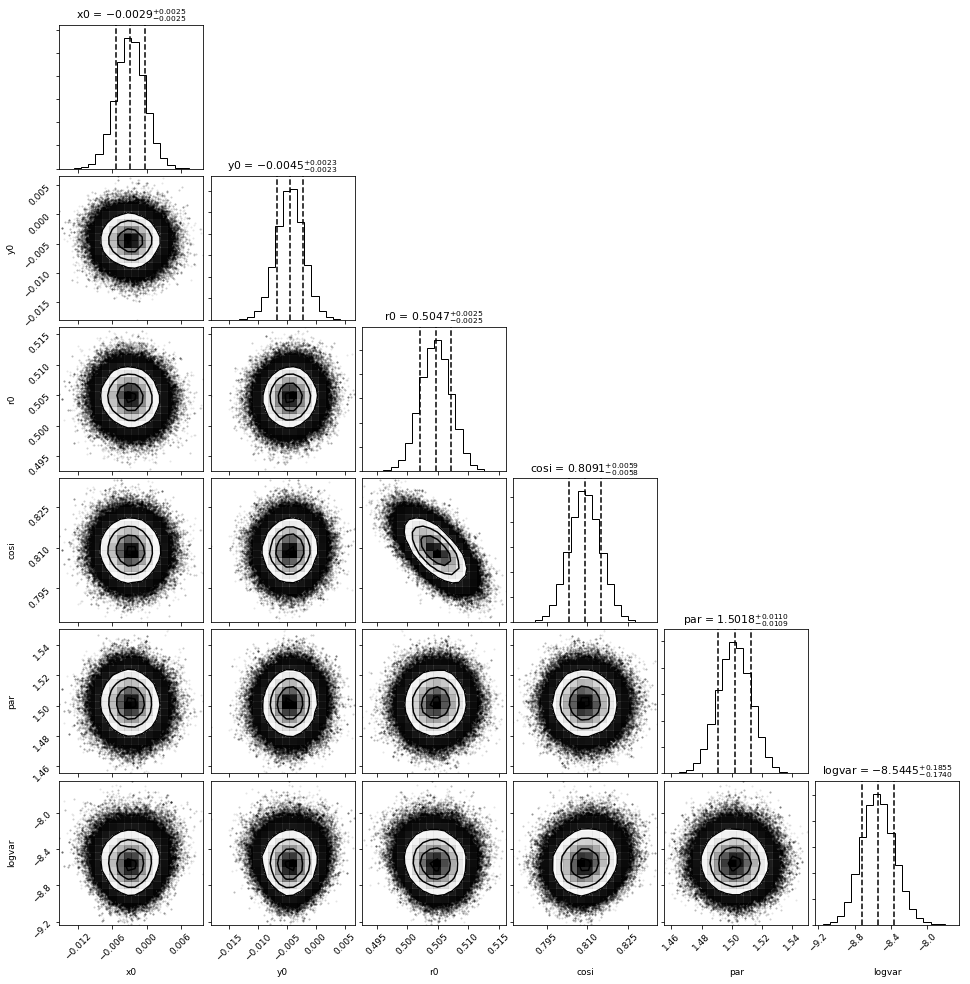

The x offset is delta_x = -2.89e-03 arcsec (+2.5e-03, -2.5e-03)
The y offset is delta_y = -4.45e-03 arcsec (+2.3e-03, -2.3e-03)
The median semi-major axis is r = 0.5047 arcsec (+0.0025, -0.0025) 
or 61.07 AU (+0.28, -0.28)
The incl is i = 36.00 deg (+0.56, -0.58)
The median position angle is PA = 86.04 deg (+0.63, -0.62)
The median log-variance in the pixel offsets from the true ellipse is -8.544e+00


In [18]:
plot_corner(sampler3, 500, 1)
sampler_results(sampler3, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.998e-03 arcsec, delta_y = -2.321e-03 arcsec
The MLE semi-major axis is r = 0.314 arcsec
The MLE inclination is i = 31.787 degrees
The MLE position angle is PA = 82.164 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.715e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


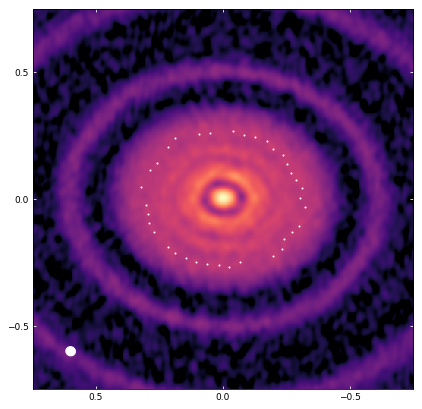

In [19]:
# Extract the ring that's at ~40 AU
xcoords4, ycoords4 = cont.extract_ring(36,44,tbins = -176+8*np.arange(45))

cont.plot_extracted_ring(cont,xcoords4, ycoords4, 0.5, 1.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_4 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     .33,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords4, ycoords4)

In [20]:
sampler4 = run_mcmc(nwalkers, nthreads, nsteps, mle_4, lnprob, xcoords4, ycoords4)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

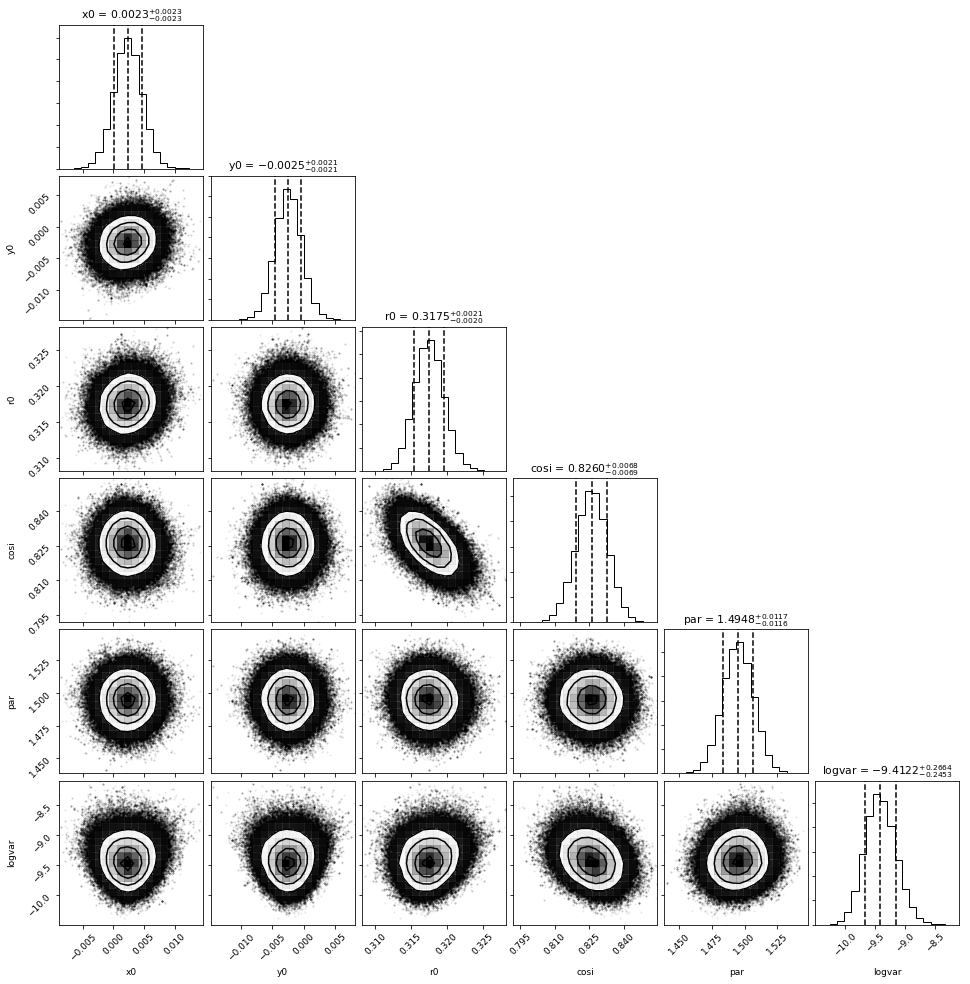

The x offset is delta_x = 2.32e-03 arcsec (+2.3e-03, -2.3e-03)
The y offset is delta_y = -2.49e-03 arcsec (+2.1e-03, -2.1e-03)
The median semi-major axis is r = 0.3175 arcsec (+0.0021, -0.0020) 
or 38.42 AU (+0.25, -0.25)
The incl is i = 34.31 deg (+0.69, -0.69)
The median position angle is PA = 85.65 deg (+0.67, -0.67)
The median log-variance in the pixel offsets from the true ellipse is -9.412e+00


In [22]:
plot_corner(sampler4, 500, 1)
sampler_results(sampler4, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


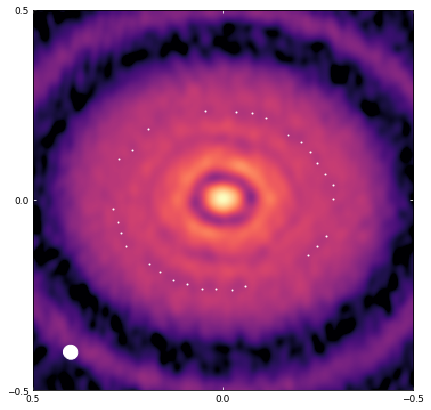

In [23]:
# Extract the gap that's at ~35 AU
xcoords5, ycoords5 = cont.extract_ring(33,37,tbins = -176+8*np.arange(45), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords5, ycoords5, 0.5, 1)

In [24]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_5 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     35/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords5, ycoords5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 5.069e-03 arcsec, delta_y = -3.176e-03 arcsec
The MLE semi-major axis is r = 0.290 arcsec
The MLE inclination is i = 35.929 degrees
The MLE position angle is PA = 84.564 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.074e+01


In [25]:
sampler5 = run_mcmc(nwalkers, nthreads, nsteps, mle_5, lnprob, xcoords5, ycoords5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

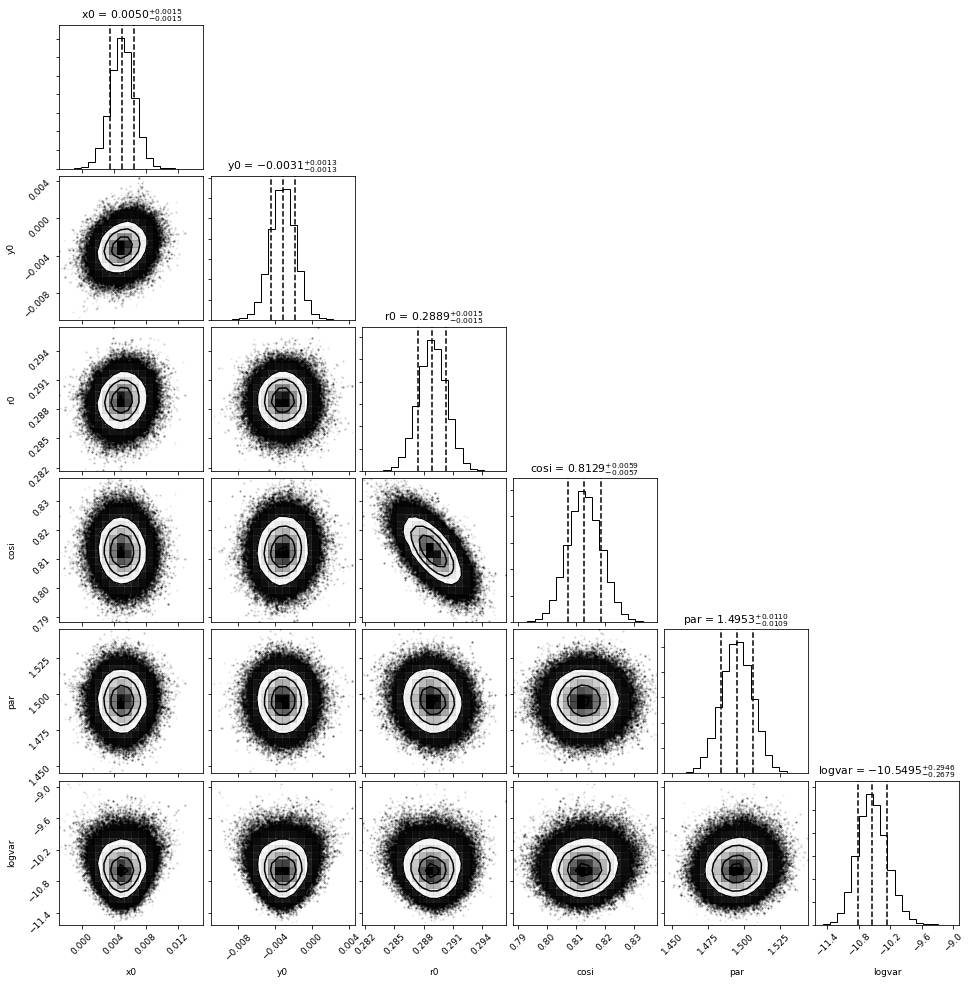

The x offset is delta_x = 5.03e-03 arcsec (+1.5e-03, -1.5e-03)
The y offset is delta_y = -3.13e-03 arcsec (+1.3e-03, -1.3e-03)
The median semi-major axis is r = 0.2889 arcsec (+0.0015, -0.0015) 
or 34.96 AU (+0.16, -0.16)
The incl is i = 35.62 deg (+0.56, -0.58)
The median position angle is PA = 85.67 deg (+0.63, -0.63)
The median log-variance in the pixel offsets from the true ellipse is -1.055e+01


In [27]:
plot_corner(sampler5, 500, 1)
sampler_results(sampler5, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 5.178e-03 arcsec, delta_y = -4.763e-03 arcsec
The MLE semi-major axis is r = 0.228 arcsec
The MLE inclination is i = 33.901 degrees
The MLE position angle is PA = 90.227 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.638e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


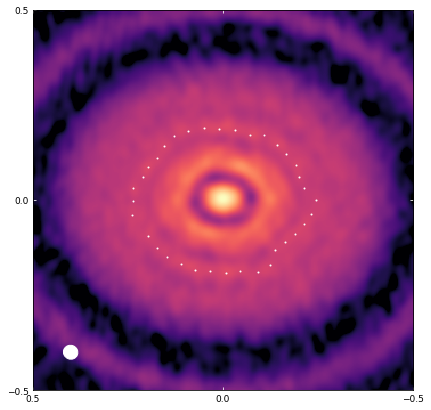

In [28]:
# Extract the gap that's at ~27 AU
xcoords6, ycoords6 = cont.extract_ring(24,30,tbins = -175+10*np.arange(36))

cont.plot_extracted_ring(cont,xcoords6, ycoords6, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_6 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     27/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords6, ycoords6)

In [29]:
sampler6 = run_mcmc(nwalkers, nthreads, nsteps, mle_6, lnprob, xcoords6, ycoords6)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

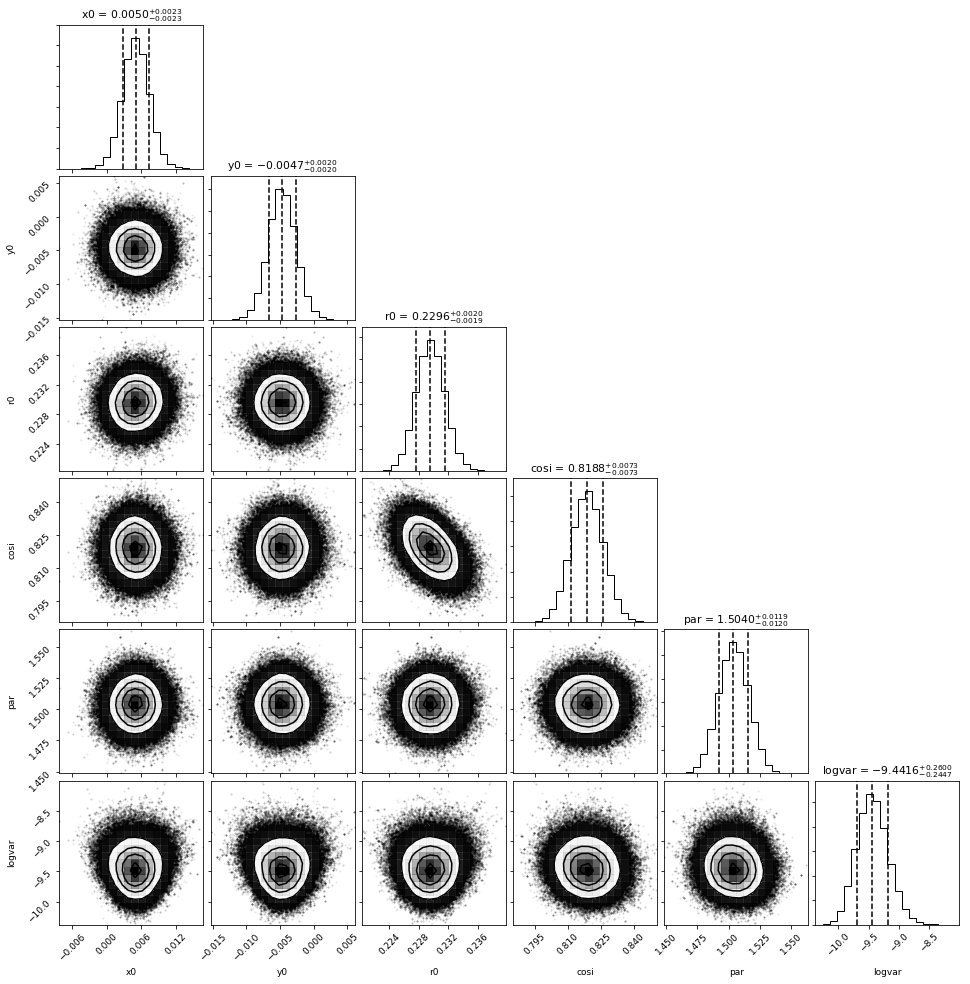

The x offset is delta_x = 5.04e-03 arcsec (+2.3e-03, -2.3e-03)
The y offset is delta_y = -4.71e-03 arcsec (+2.0e-03, -2.0e-03)
The median semi-major axis is r = 0.2296 arcsec (+0.0020, -0.0019) 
or 27.78 AU (+0.25, -0.24)
The incl is i = 35.03 deg (+0.72, -0.74)
The median position angle is PA = 86.17 deg (+0.68, -0.69)
The median log-variance in the pixel offsets from the true ellipse is -9.442e+00


In [31]:
plot_corner(sampler6, 500, 1)
sampler_results(sampler6, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 2.469e-03 arcsec, delta_y = -4.245e-03 arcsec
The MLE semi-major axis is r = 0.197 arcsec
The MLE inclination is i = 35.798 degrees
The MLE position angle is PA = 85.500 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.050e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


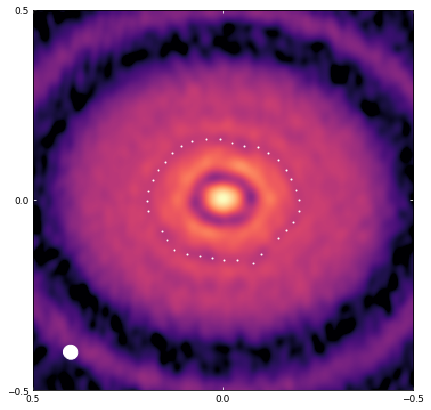

In [32]:
# Extract the gap that's at ~23 AU
xcoords7, ycoords7 = cont.extract_ring(20,26,tbins = -175+10*np.arange(36), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords7, ycoords7, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_7 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     23/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords7, ycoords7)

In [33]:
sampler7 = run_mcmc(nwalkers, nthreads, nsteps, mle_7, lnprob, xcoords7, ycoords7)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

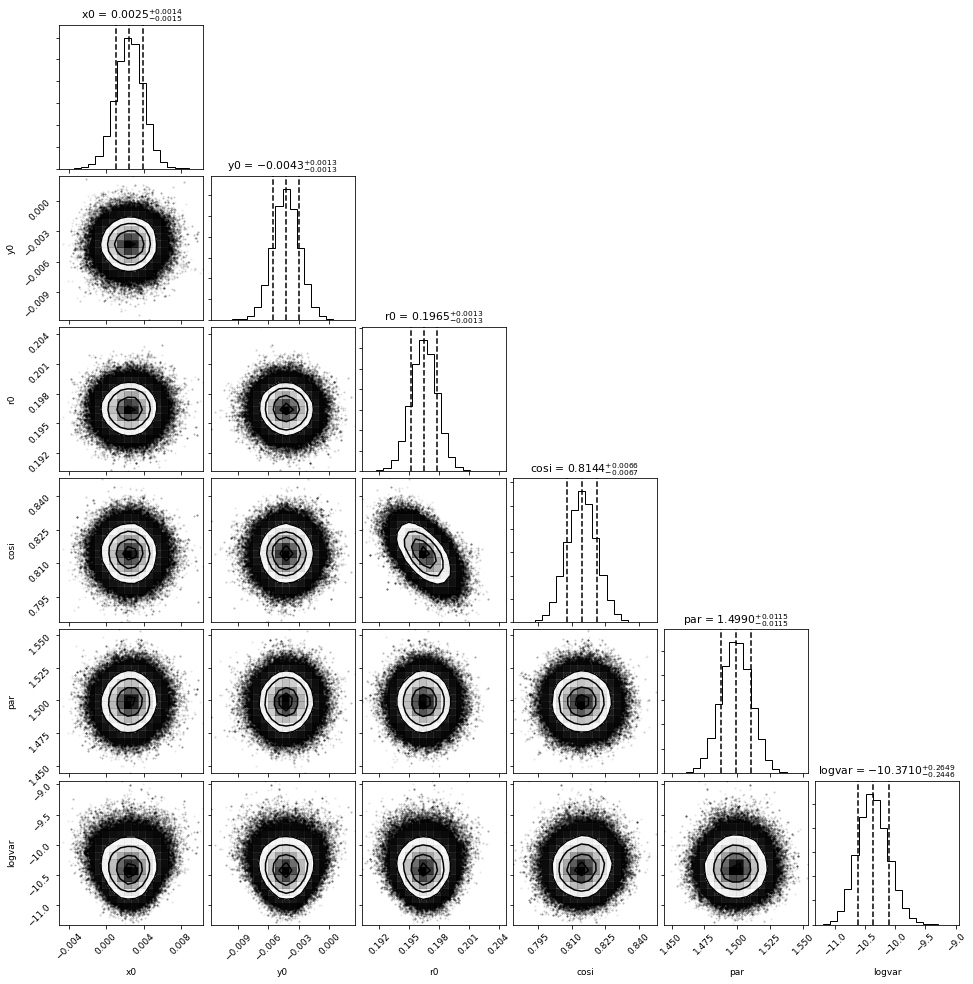

The x offset is delta_x = 2.49e-03 arcsec (+1.4e-03, -1.5e-03)
The y offset is delta_y = -4.25e-03 arcsec (+1.3e-03, -1.3e-03)
The median semi-major axis is r = 0.1965 arcsec (+0.0013, -0.0013) 
or 23.77 AU (+0.16, -0.16)
The incl is i = 35.47 deg (+0.66, -0.66)
The median position angle is PA = 85.89 deg (+0.66, -0.66)
The median log-variance in the pixel offsets from the true ellipse is -1.037e+01


In [35]:
plot_corner(sampler7, 500, 1)
sampler_results(sampler7, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.883e-03 arcsec, delta_y = -4.037e-03 arcsec
The MLE semi-major axis is r = 0.118 arcsec
The MLE inclination is i = 34.123 degrees
The MLE position angle is PA = 80.842 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.152e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


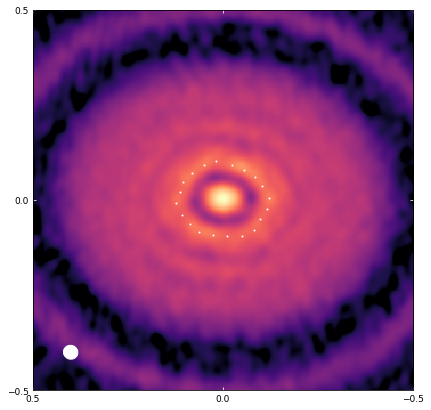

In [36]:
# Extract the ring that's at ~14 AU
xcoords8, ycoords8 = cont.extract_ring(10,20,tbins = -171+18*np.arange(20), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords8, ycoords8, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_8 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     14/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords8, ycoords8)

In [37]:
sampler8 = run_mcmc(nwalkers, nthreads, nsteps, mle_8, lnprob, xcoords8, ycoords8)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

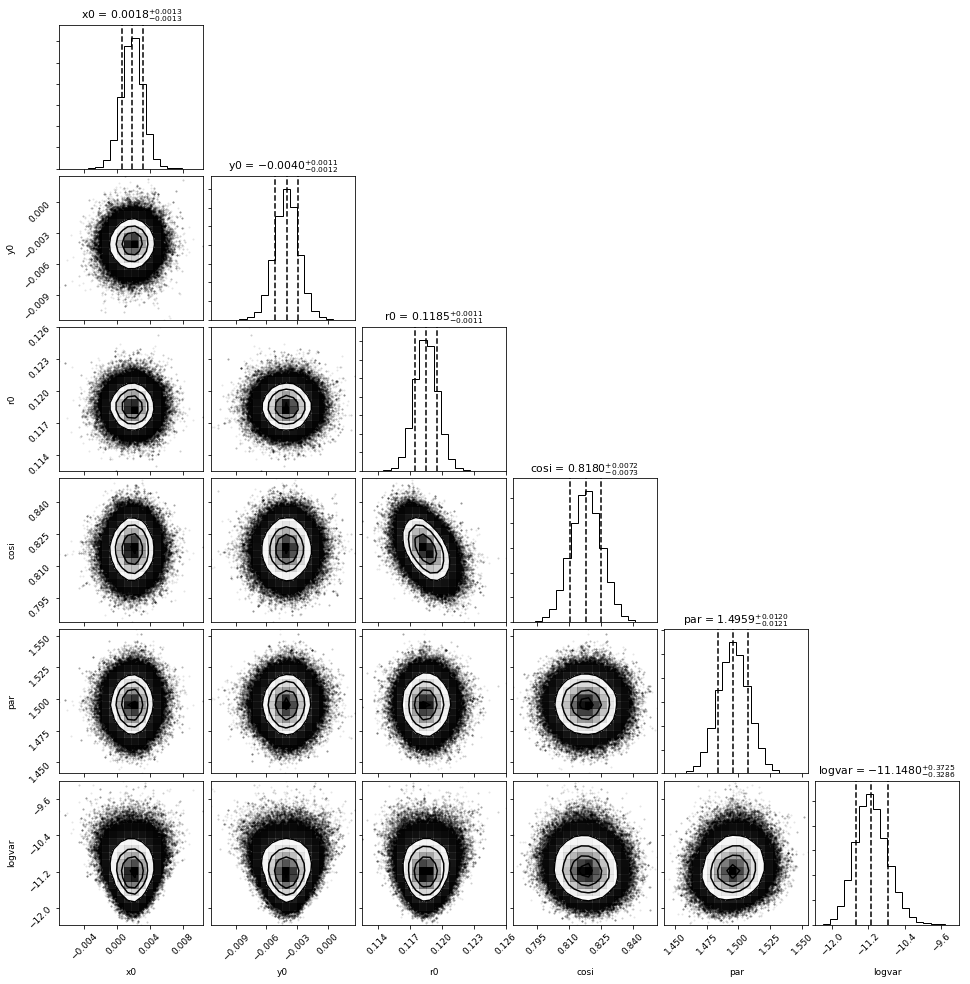

The x offset is delta_x = 1.85e-03 arcsec (+1.3e-03, -1.3e-03)
The y offset is delta_y = -4.03e-03 arcsec (+1.1e-03, -1.2e-03)
The median semi-major axis is r = 0.1185 arcsec (+0.0011, -0.0011) 
or 14.34 AU (+0.14, -0.14)
The incl is i = 35.11 deg (+0.72, -0.73)
The median position angle is PA = 85.71 deg (+0.69, -0.69)
The median log-variance in the pixel offsets from the true ellipse is -1.115e+01


In [39]:
plot_corner(sampler8, 500, 1)
sampler_results(sampler8, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 6.962e-03 arcsec, delta_y = -3.426e-03 arcsec
The MLE semi-major axis is r = 0.813 arcsec
The MLE inclination is i = 33.063 degrees
The MLE position angle is PA = 85.842 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.039e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


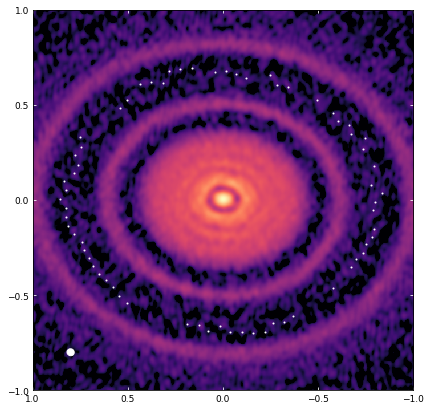

In [40]:
# Extract the ring that's at ~100 AU
xcoords9, ycoords9 = cont.extract_ring(95,105,tbins = -178+4*np.arange(90), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords9, ycoords9, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_9 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     100/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords9, ycoords9)

In [41]:
sampler9 = run_mcmc(nwalkers, nthreads, nsteps, mle_9, lnprob, xcoords9, ycoords9)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

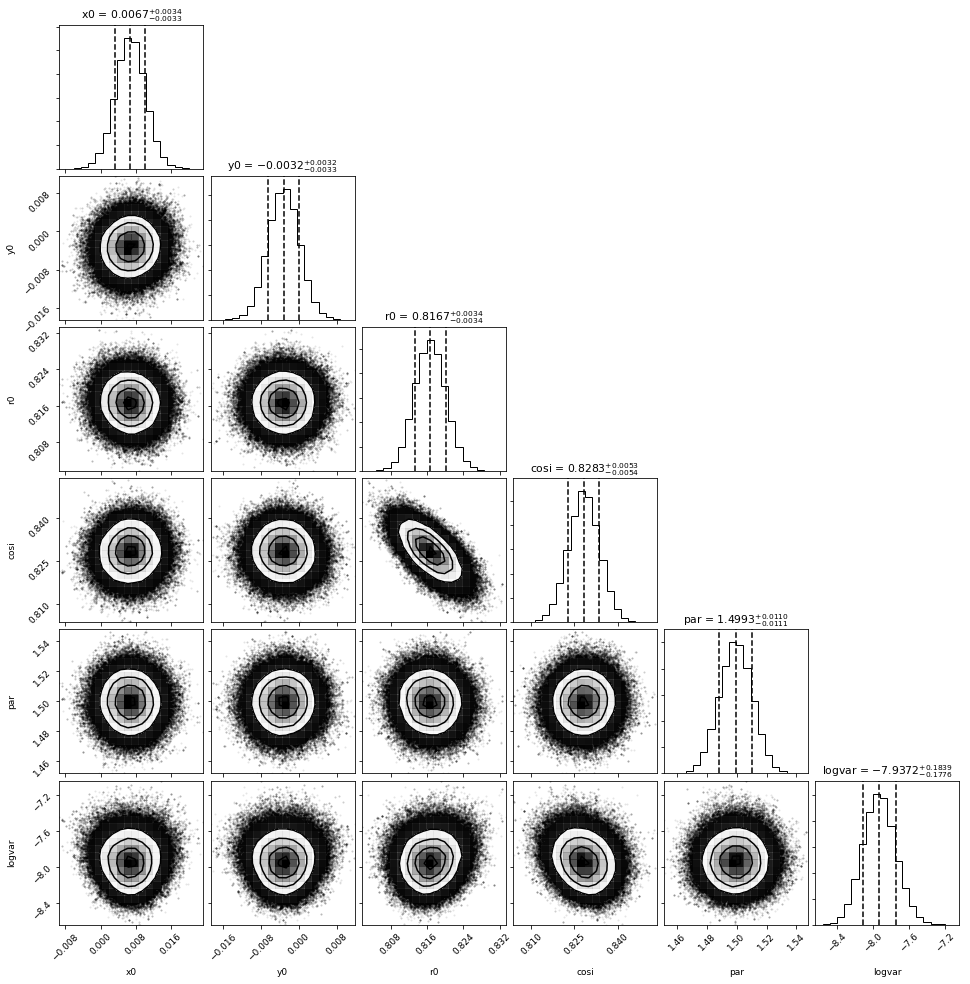

The x offset is delta_x = 6.73e-03 arcsec (+3.4e-03, -3.3e-03)
The y offset is delta_y = -3.21e-03 arcsec (+3.2e-03, -3.3e-03)
The median semi-major axis is r = 0.8167 arcsec (+0.0034, -0.0034) 
or 98.82 AU (+0.39, -0.40)
The incl is i = 34.08 deg (+0.55, -0.55)
The median position angle is PA = 85.91 deg (+0.63, -0.63)
The median log-variance in the pixel offsets from the true ellipse is -7.937e+00


In [43]:
plot_corner(sampler9, 500, 1)
sampler_results(sampler9, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -3.813e-03 arcsec, delta_y = -1.458e-03 arcsec
The MLE semi-major axis is r = 0.866 arcsec
The MLE inclination is i = 33.650 degrees
The MLE position angle is PA = 86.020 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.114e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


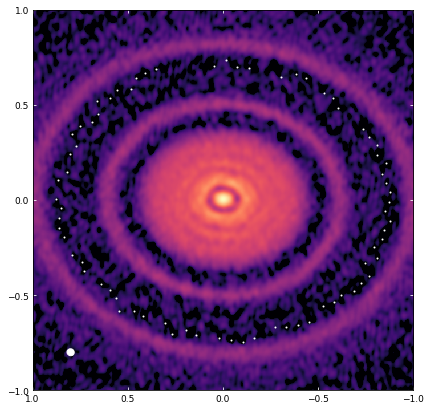

In [44]:
# Extract the gap that's at ~105 AU
xcoords10, ycoords10 = cont.extract_ring(100,110,tbins = -178+4*np.arange(90), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords10, ycoords10, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_10 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     105/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords10, ycoords10)

In [45]:
sampler10 = run_mcmc(nwalkers, nthreads, nsteps, mle_10, lnprob, xcoords10, ycoords10)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

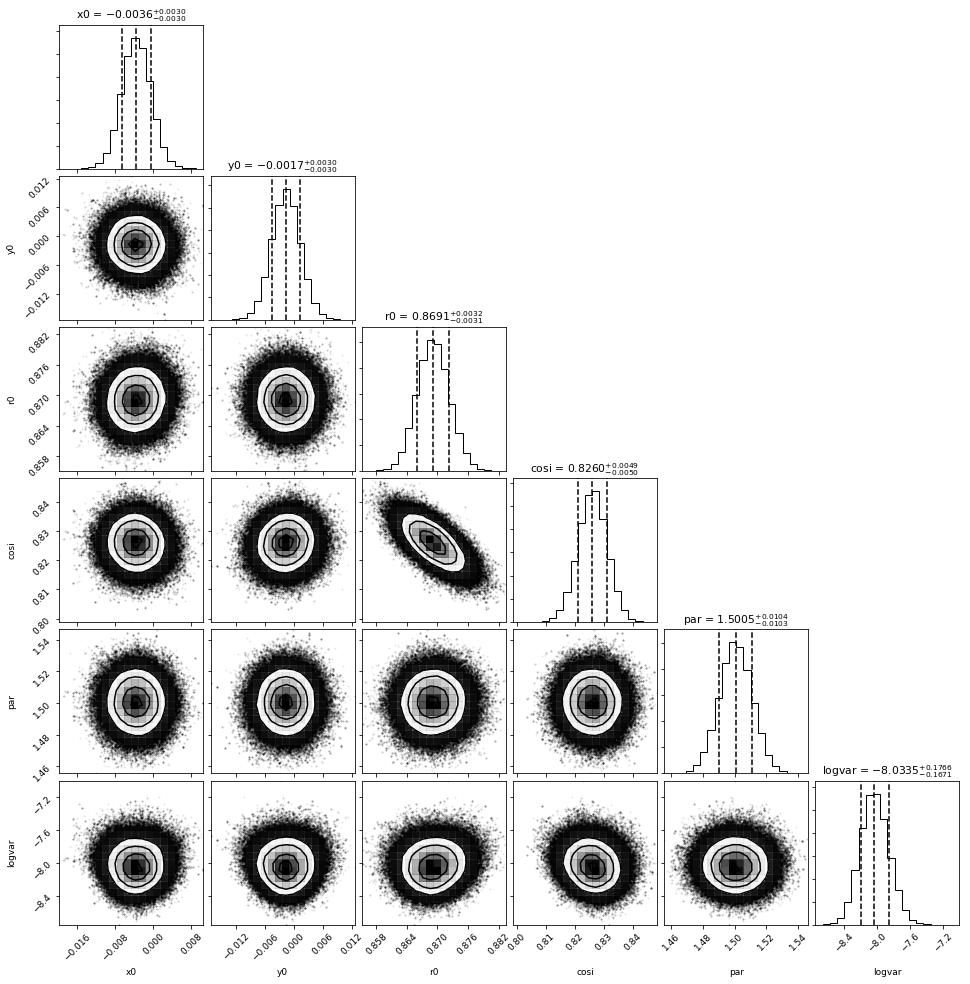

The x offset is delta_x = -3.60e-03 arcsec (+3.0e-03, -3.0e-03)
The y offset is delta_y = -1.70e-03 arcsec (+3.0e-03, -3.0e-03)
The median semi-major axis is r = 0.8691 arcsec (+0.0032, -0.0031) 
or 105.17 AU (+0.36, -0.36)
The incl is i = 34.31 deg (+0.51, -0.50)
The median position angle is PA = 85.97 deg (+0.60, -0.59)
The median log-variance in the pixel offsets from the true ellipse is -8.034e+00


In [47]:
plot_corner(sampler10, 500, 1)
sampler_results(sampler10, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.516e-03 arcsec, delta_y = -6.800e-03 arcsec
The MLE semi-major axis is r = 0.741 arcsec
The MLE inclination is i = 33.727 degrees
The MLE position angle is PA = 86.886 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.363e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


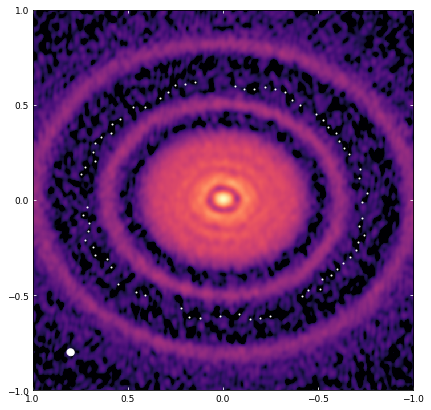

In [48]:
# Extract the gap that's at ~90 AU
xcoords11, ycoords11 = cont.extract_ring(85,95,tbins = -178+4*np.arange(90), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords11, ycoords11, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_11 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     95/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords11, ycoords11)

In [49]:
sampler11 = run_mcmc(nwalkers, nthreads, nsteps, mle_11, lnprob, xcoords11, ycoords11)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

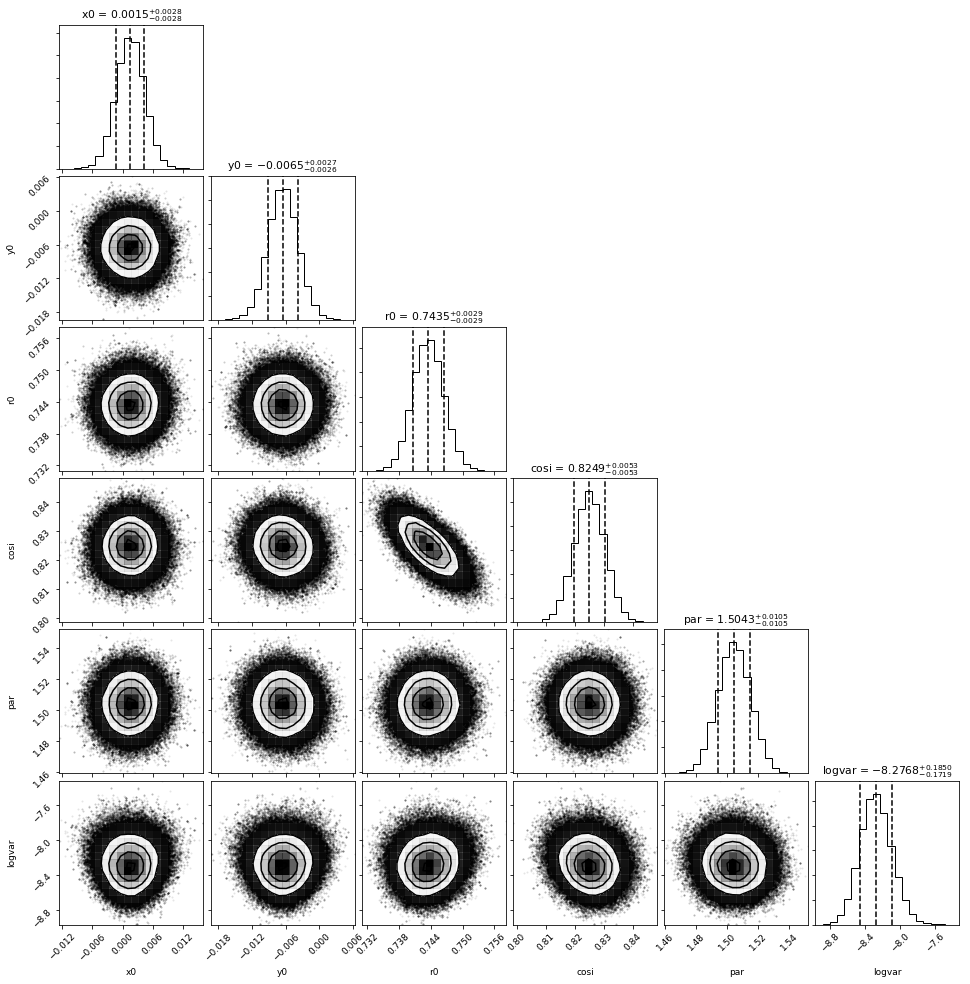

The x offset is delta_x = 1.51e-03 arcsec (+2.8e-03, -2.8e-03)
The y offset is delta_y = -6.51e-03 arcsec (+2.7e-03, -2.6e-03)
The median semi-major axis is r = 0.7435 arcsec (+0.0029, -0.0029) 
or 89.96 AU (+0.32, -0.32)
The incl is i = 34.42 deg (+0.53, -0.54)
The median position angle is PA = 86.19 deg (+0.60, -0.60)
The median log-variance in the pixel offsets from the true ellipse is -8.277e+00


In [51]:
plot_corner(sampler11, 500, 1)
sampler_results(sampler11, 500, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.085e-03 arcsec, delta_y = -3.941e-03 arcsec
The MLE semi-major axis is r = 0.073 arcsec
The MLE inclination is i = 38.341 degrees
The MLE position angle is PA = 78.422 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.480e+01


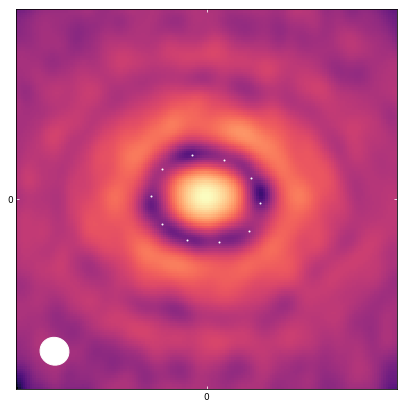

In [52]:
# Extract the gap that's at ~10 AU
xcoords12, ycoords12 = cont.extract_ring(5,15,tbins = -162+36*np.arange(10), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords12, ycoords12, 0.4, 0.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_12 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     10/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords12, ycoords12)

In [54]:
sampler12 = run_mcmc(nwalkers, nthreads, nsteps, mle_12, lnprob, xcoords12, ycoords12)


/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [55]:
np.savez("AS209ellipsechains.npz", BR120 = sampler1.chain, BR74 = sampler2.chain, DA61 = sampler3.chain, 
         BR38 = sampler4.chain, DA35 = sampler5.chain, BR28 = sampler6.chain, DA24 = sampler7.chain, 
        BR14 = sampler8.chain, BR99 = sampler9.chain, DA105 = sampler10.chain, DA90=sampler11.chain, DA9 = sampler12.chain)

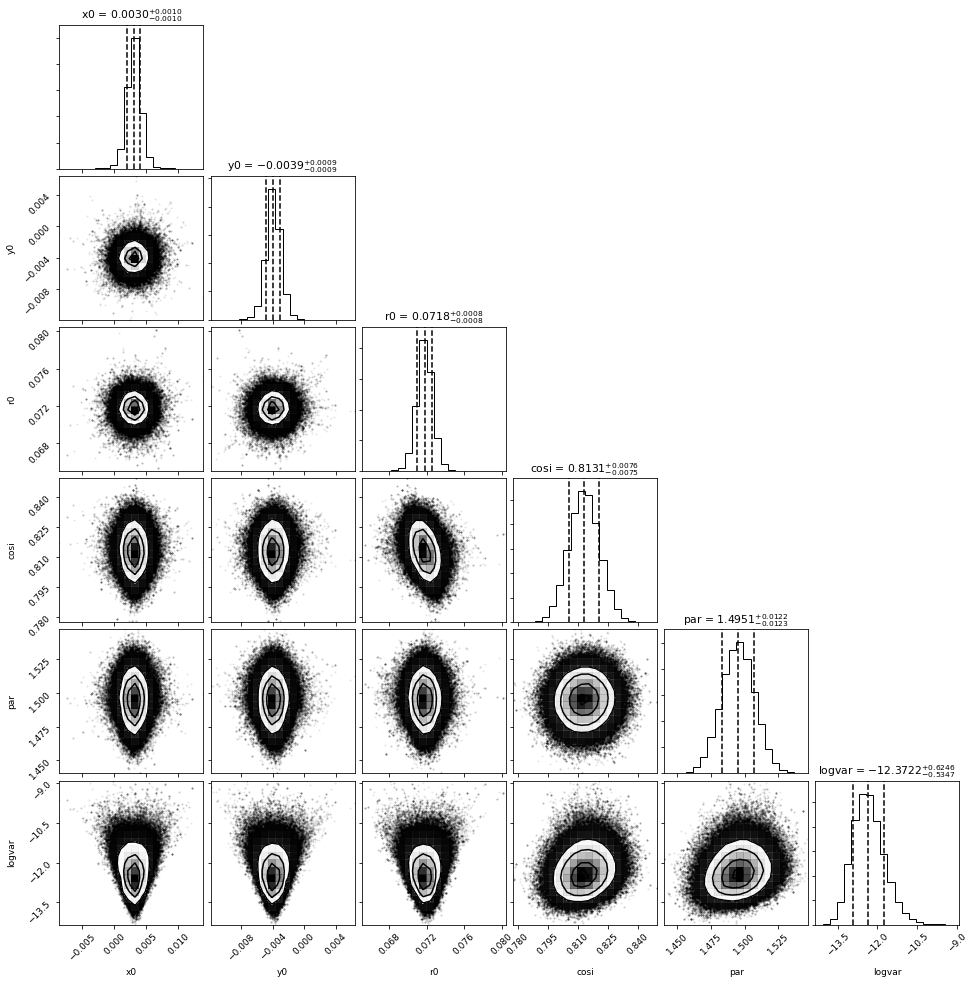

The x offset is delta_x = 3.05e-03 arcsec (+9.9e-04, -1.0e-03)
The y offset is delta_y = -3.92e-03 arcsec (+8.9e-04, -8.8e-04)
The median semi-major axis is r = 0.0718 arcsec (+0.0008, -0.0008) 
or 8.68 AU (+0.11, -0.11)
The incl is i = 35.60 deg (+0.74, -0.76)
The median position angle is PA = 85.66 deg (+0.70, -0.70)
The median log-variance in the pixel offsets from the true ellipse is -1.237e+01


In [56]:
plot_corner(sampler12, 500, 1)
sampler_results(sampler12, 500, cont.src_distance)

In [3]:

maxrad = 150
radialbins = 0.5+np.arange(0, maxrad)

newcont = Continuum(disk['filename'], 1.7e-3,-3.2e-3, 85.8, 34.9,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))





max [14, 27, 38, 74, 97, 120, 141]
min [8, 23, 35, 60, 89, 105, 137]


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


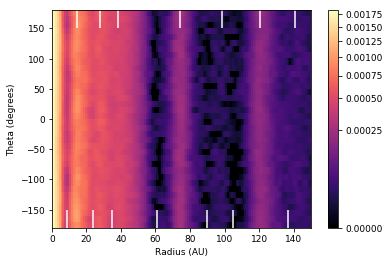

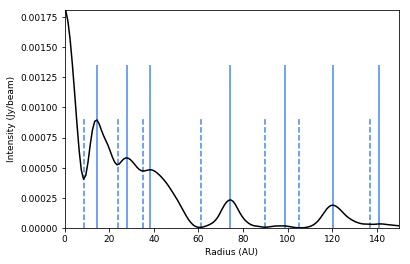

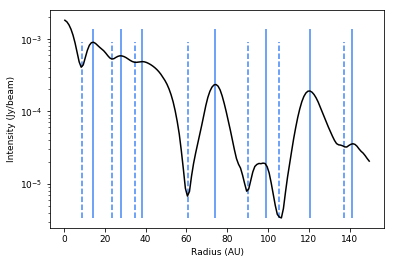

(0, 150)

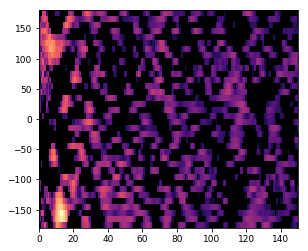

In [58]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
gaps = [8.7, 23.8, 35.0, 61, 90.0, 105.2,137]
rings = [14.3, 27.8,38.4, 74, 98.8, 120.3,141]
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = 150)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)

In [46]:
print(np.arange(0.5, 5, 0.1))
print(np.arange(0.5,5,1))

[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4
  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9]
[ 0.5  1.5  2.5  3.5  4.5]


In [5]:
calc_contrast(8.69, 14.34, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.45215191249607439, 0.019392785783763834)

In [4]:
measure_widths(8.69, 14.34, radialbins, newsurfbrightness, 0, 24)

(4.6999999999999993, 8.9999999999999982)

In [6]:
calc_contrast(23.77, 27.8, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.90080747451573118, 0.012584102588311002)

In [7]:
measure_widths(23.77, 27.8, radialbins, newsurfbrightness, 14, 35)

(3.1999999999999993, 4.6999999999999993)

In [7]:
calc_contrast(34.96, 38.4, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.98152094658812661, 0.01082587352381901)

In [8]:
measure_widths(34.96, 38.4, radialbins, newsurfbrightness, 32, 45)

(2.7999999999999972, 2.7000000000000028)

In [8]:
calc_contrast(61.0, 73.96, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.029239838302868418, 0.0098935407951477473)

In [10]:
measure_widths(61.0, 73.96, radialbins, newsurfbrightness, 40, 90)

(15.5, 9.2999999999999972)

In [10]:
calc_contrast(90,98.8, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.41368131649130746, 0.11241956393478879)

In [16]:
measure_widths(90,98.8, radialbins, newsurfbrightness, 74, 105)

(4.7999999999999972, 8.5)

In [7]:
Imean = 0.5*(newsurfbrightness[98]+newsurfbrightness[90])
print(Imean)
np.argmin(np.abs(Imean - newsurfbrightness[98:]))+98

1.37434984829e-05


100

In [11]:
measure_widths(105.2, 120.3, radialbins, newsurfbrightness, 100, 137)

(14.600000000000009, 11.399999999999991)

In [7]:
measure_widths(105.2, 120.3, radialbins, newsurfbrightness, 74, 137)

(35.5, 11.399999999999991)

In [12]:
calc_contrast(105.2, 120.3, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.018181449529576878, 0.0094759614922652387)

In [13]:
calc_contrast(137.001, 141.001, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.90489203880971547, 0.056157358691533925)

In [15]:
measure_widths(137.001, 141.001, radialbins, newsurfbrightness, 130, 150)

(4.2000000000000171, 3.1999999999999886)

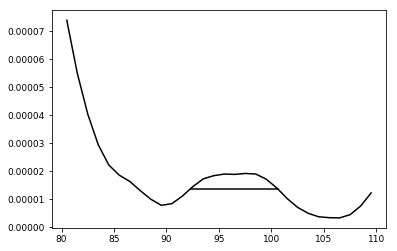

In [10]:
plt.plot(radialbins[80:110], newsurfbrightness[80:110], color = 'black')
plt.hlines(0.0000137, 92.2, 100.7)

140.5


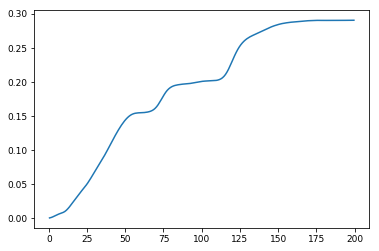

In [4]:
bins = 0.5+1*np.arange(0, 200)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])